In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [185]:
def plot_history(history, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [167]:
def train(model, X_train, X_test, y_train, y_test, learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
            
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
    return torch.tensor(history)

In [146]:
d = load_diabetes()
len(d.data)

442

In [147]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [148]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [149]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

Epoch    0 MSE train loss    28542.150   test loss    31042.748
Epoch  150 MSE train loss      476.024   test loss     3463.151
Epoch  300 MSE train loss      314.949   test loss     3640.141
Epoch  450 MSE train loss      244.576   test loss     3466.416
Epoch  600 MSE train loss      246.778   test loss     3564.229
Epoch  750 MSE train loss      225.722   test loss     3632.541
Epoch  900 MSE train loss      217.823   test loss     3590.617
Epoch 1050 MSE train loss      201.241   test loss     3728.835
Epoch 1200 MSE train loss      204.553   test loss     3734.315
Epoch 1350 MSE train loss      206.220   test loss     3812.948
Epoch 1500 MSE train loss      190.281   test loss     3830.319
LAST       MSE train loss      190.281   test loss     3830.319


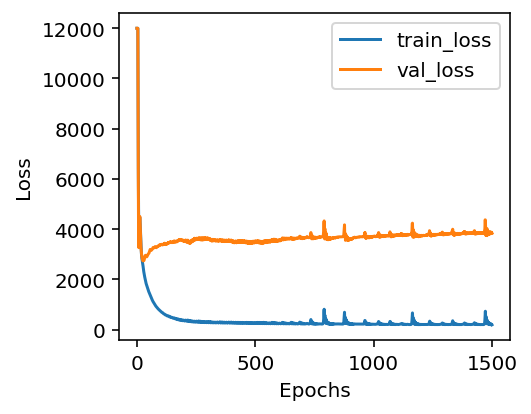

In [209]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

with tsensor.clarify():
    history = train(model, X_train, X_test, y_train, y_test,
                    learning_rate=.35, nepochs=1500,
                    weight_decay=.2)

plot_history(torch.clamp(history, 0, 12000))